In [ ]:
pip install segmentation-models

     |████████████████████████████████| 50 kB 4.1 MB/s 


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import pickle
import matplotlib.patches as patches
import re
import random 
from sklearn.model_selection import train_test_split
import cv2
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from PIL import Image
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Model,load_model
from keras.regularizers import l2
import datetime
%load_ext tensorboard
import segmentation_models
from segmentation_models import Unet
from segmentation_models import get_preprocessing
import imgaug.augmenters as iaa
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()
from tensorflow.keras.losses import binary_crossentropy
from tqdm import tqdm

Segmentation Models: using `keras` framework.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
test_image=[i for i in os.listdir('/content/drive//My Drive/Steel_Detection /test_images')]

In [ ]:
len(test_image)

5516

# Final Pipeline

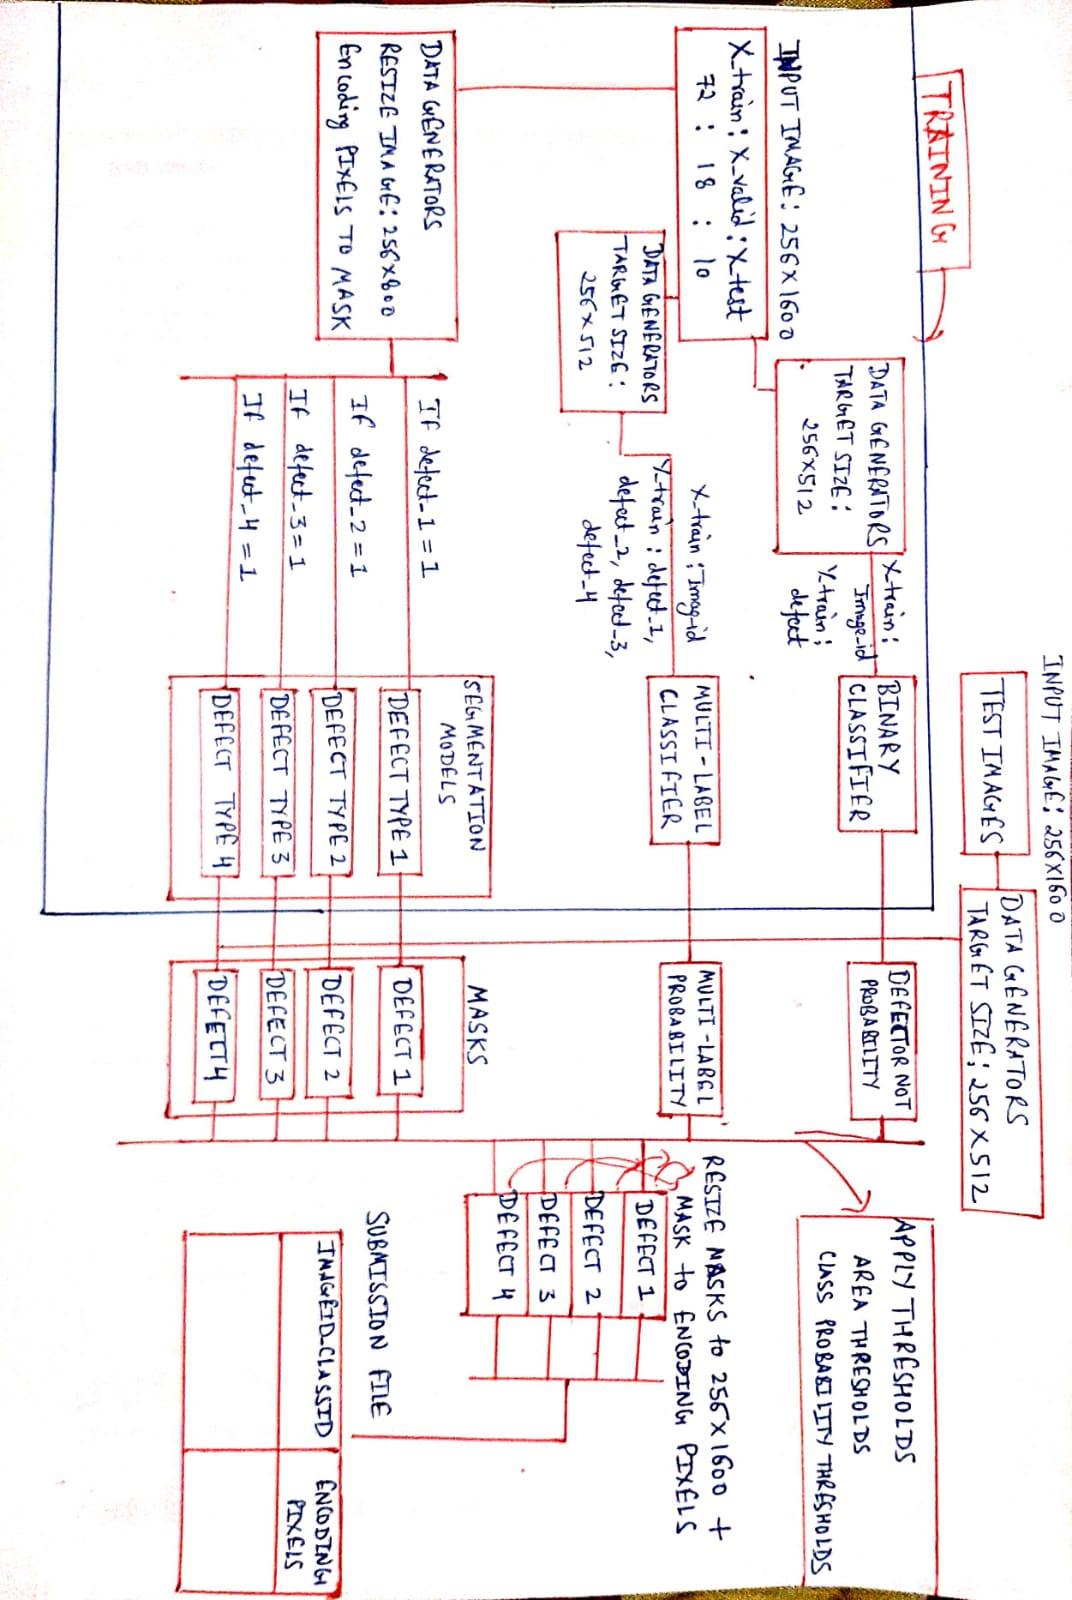

* Binary Classifier trained with all Images with 1 output probability i.e. [defect] which tells whether whether Image have defect or not while Multi-label Classifier trained only with Images with defect. Multi-label Classifier have 4 output probability i.e. [defect_1,defect_2,defect_3,defect_4]. 

* Segmentation models are trained on each defect separately and predicts mask for each defect. Overall,we have 4 segment models i.e. one for each defect. There are total 6 models that are saved and later uses area threshold and class probability (different for each defect, depending on particular defect mask area and class probability).

* At last Encoded Pixels for test images are predicted and submitted. While training one must take care that proper data is fed to each model in the network which will help to reduce loss.

In [ ]:
def f1_score(y_true, y_pred): 
    #https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d
    #https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
    true_positives=K.sum(K.round(K.clip(y_true*y_pred,0,1)))   #calculates number of true positives
    possible_positives=K.sum(K.round(K.clip(y_true,0,1)))      #calculates number of actual positives
    predicted_positives=K.sum(K.round(K.clip(y_pred,0,1)))     

    #K.epsilon takes care of non-zero divisions
    #was modified by adding the constant epsilon, in order to avoid division by 0. Thus NaN will not be computed.
    precision=true_positives/(predicted_positives +K.epsilon())
    recall=true_positives/(possible_positives+K.epsilon())
    f1_val=2*(precision*recall)/(precision+recall+K.epsilon()) 
    return f1_val

In [ ]:
#https://stackoverflow.com/questions/31273652/how-to-calculate-dice-coefficient-for-measuring-accuracy-of-image-segmentation-i
def dice_coef(y_true,y_pred):
    y_true_f=tf.reshape(tf.dtypes.cast(y_true, tf.float32),[-1])
    y_pred_f=tf.reshape(tf.dtypes.cast(y_pred, tf.float32),[-1])
    intersection=tf.reduce_sum(y_true_f*y_pred_f)
    return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)

#https://stackoverflow.com/questions/49785133/keras-dice-coefficient-loss-function-is-negative-and-increasing-with-epochs
def dice_loss(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    return (1-dice_coefficient(y_true, y_pred))

#defining function for calculation of loss function: binary cross entropy + dice loss
def bce_dice_loss(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    return binary_crossentropy(y_true, y_pred) + (1-dice_coef(y_true, y_pred))

In [ ]:
def sum_pixel(i):
    return sum([int(k) for k in i.split(' ')[1::2]])

In [ ]:
#Reference: https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def mask2rle(img):
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
# Implementing custom data generator
#https://towardsdatascience.com/implementing-custom-data-generators-in-keras-de56f013581c
class test_DataGenerator(keras.utils.all_utils.Sequence):
  
  def __init__(self,dataframe,batch_size=1,shuffle=False,preprocess=None,info={}):
    self.batch_size = batch_size
    self.df = dataframe
    self.indices = self.df.index.tolist()
    self.preprocess = preprocess
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    return len(self.indices) // (self.batch_size)

  def __getitem__(self, index):
    index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
    batch = [self.indices[k] for k in index]
        
    X= self.__get_data(batch)
    return X

  def on_epoch_end(self):
    self.index = np.arange(len(self.indices))
    if self.shuffle == True:
      np.random.shuffle(self.index)

  def __get_data(self, batch):
    X = np.empty((self.batch_size,256,800,3),dtype=np.float32) # image place-holders
    

    for i, id in enumerate(batch):
      X[i,] = Image.open('/content/drive//My Drive/Steel_Detection /test_images/' + str(self.df['image_id'].loc[id])).resize((800,256))   
      
                
      # preprocess input
    if self.preprocess!=None: X = self.preprocess(X)

    return X

In [ ]:
binary=load_model('/content/drive//My Drive/Steel_Detection /binary_Xception_2.h5',custom_objects={'f1_score':f1_score})
multi=load_model('/content/drive//My Drive/Steel_Detection /multi_label.h5',custom_objects={'f1_score':f1_score})
segment_1=load_model('/content/drive//My Drive/Steel_Detection /segmentation_defect_1.h5',custom_objects={'bce_dice_loss':bce_dice_loss,'dice_coef':dice_coef})
segment_2=load_model('/content/drive//My Drive/Steel_Detection /segmentation_defect_2.h5',custom_objects={'bce_dice_loss':bce_dice_loss,'dice_coef':dice_coef})
segment_3=load_model('/content/drive//My Drive/Steel_Detection /segmentation_defect_3.h5',custom_objects={'bce_dice_loss':bce_dice_loss,'dice_coef':dice_coef})
segment_4=load_model('/content/drive//My Drive/Steel_Detection /segmentation_defect_4.h5',custom_objects={'bce_dice_loss':bce_dice_loss,'dice_coef':dice_coef})

* Loading all saved models.

In [ ]:
test_folder_path='/content/drive//My Drive/Steel_Detection /test_images'

In [ ]:
def threshold(X):
  t=[]
  
  for i in range(len(X)):

    if sum_pixel(X['rle_1'].iloc[i])>=300 and sum_pixel(X['rle_1'].iloc[i])<=13500 and X['defect'].iloc[i]>=0.4 and X['defect_1'].iloc[i]>=0.5: 
      t.append([X['image_id'].iloc[i]+'_1',X['rle_1'].iloc[i]])
    else:
      t.append([X['image_id'].iloc[i]+'_1',''])

    if sum_pixel(X['rle_2'].iloc[i])>=500 and sum_pixel(X['rle_2'].iloc[i])<=9000 and X['defect'].iloc[i]>=0.4 and X['defect_2'].iloc[i]>=0.5:
      t.append([X['image_id'].iloc[i]+'_2',X['rle_2'].iloc[i]])
    else:
      t.append([X['image_id'].iloc[i]+'_2',''])

    if sum_pixel(X['rle_3'].iloc[i])>=900 and sum_pixel(X['rle_3'].iloc[i])<=140000 and X['defect'].iloc[i]>=0.5 and X['defect_3'].iloc[i]>=0.6:
      t.append([X['image_id'].iloc[i]+'_3',X['rle_3'].iloc[i]])
    else:
      t.append([X['image_id'].iloc[i]+'_3',''])

    if sum_pixel(X['rle_4'].iloc[i])>=2400 and sum_pixel(X['rle_4'].iloc[i])<=120000 and X['defect'].iloc[i]>=0.4 and X['defect_4'].iloc[i]>=0.5:
      t.append([X['image_id'].iloc[i]+'_4',X['rle_4'].iloc[i]])
    else:
      t.append([X['image_id'].iloc[i]+'_4',''])
  
  df=pd.DataFrame(t,columns=['imageid_classid','rle'])
  return df

* Depending on mask area(plot drawn in EDA) and class probability thresholds are decided for each defects respectively.

In [ ]:
def predict(X):
   
   preprocess=get_preprocessing('efficientnetb5')
   datagen=ImageDataGenerator(rescale=1./255)
   data_generator=datagen.flow_from_dataframe(dataframe=X,
                                           directory=test_folder_path,
                                           x_col="image_id",
                                           class_mode=None,
                                           target_size=(256,512), 
                                           batch_size=1, 
                                           shuffle=False)
   a=[]

   pred_binary=binary.predict_generator(data_generator)
   pred_multi=multi.predict_generator(data_generator)
   classify =pd.DataFrame(pred_multi,columns=['defect_1','defect_2','defect_3','defect_4'])
   classify['defect']=pred_binary
   classify['image_id']=X['image_id']


   batch=test_DataGenerator(X,preprocess=preprocess)
   pred_1=segment_1.predict_generator(batch)
   pred_2=segment_2.predict_generator(batch)
   pred_3=segment_3.predict_generator(batch)
   pred_4=segment_4.predict_generator(batch)
   for i in range(len(pred_1)):
     v1=mask2rle(np.array((Image.fromarray((pred_1[i][:,:,0])>=0.5)).resize((1600,256))).astype(int))
     v2=mask2rle(np.array((Image.fromarray((pred_2[i][:,:,0])>=0.5)).resize((1600,256))).astype(int))
     v3=mask2rle(np.array((Image.fromarray((pred_3[i][:,:,0])>=0.5)).resize((1600,256))).astype(int))
     v4=mask2rle(np.array((Image.fromarray((pred_4[i][:,:,0])>=0.5)).resize((1600,256))).astype(int))
     a.append([X.image_id.iloc[i],v1,v2,v3,v4])
   segment=pd.DataFrame(a,columns=['image_id','rle_1','rle_2','rle_3','rle_4'])
   
   df=classify.merge(segment,on=['image_id']) 

   df1=threshold(df)
   return df1

* First compute binary and multi-label classification later use segmentation model and after checking thresholds for each defect finally predicts Encoded pixels for each image id and class id .

#Prediction on Unseen given Test data

In [ ]:
test=pd.DataFrame(test_image,columns=['image_id'])
test1=test[0:20]
test1=test1.reset_index().drop('index',axis=1)
data=predict(test1)
data

Found 20 validated image filenames.


,imageid_classid,rle
0,dc5acf74b.jpg_1,
1,dc5acf74b.jpg_2,
2,dc5acf74b.jpg_3,
3,dc5acf74b.jpg_4,
4,d9411a571.jpg_1,
...,...,...
75,dc74717d9.jpg_4,
76,d82a63ce0.jpg_1,
77,d82a63ce0.jpg_2,
78,d82a63ce0.jpg_3,395799 19 396055 19 396295 43 396551 43 396802...


In [ ]:
a=[]
b=[]
for i in data.imageid_classid.values:	
  k,l=i.split('_')
  a.append(k)
  b.append(l)

In [ ]:
df=pd.DataFrame(columns=['image_Id','class_Id','EncodedPixels'])
df['image_id']=a
df['class_id']=b
df['EncodedPixels']=data.rle.values
df.drop(['image_Id','class_Id'],axis=1,inplace=True)

In [ ]:
#https://www.analyticsvidhya.com/blog/2020/03/pivot-table-pandas-python/
df1=pd.pivot_table(df,values='EncodedPixels',index='image_id',columns='class_id',aggfunc=np.sum).astype(str)
df1=df1.reset_index()
df1.columns=['image_id','rle_1','rle_2','rle_3','rle_4'] 
df1

,image_id,rle_1,rle_2,rle_3,rle_4
0,d118e5d28.jpg,,,46829 8 47085 8 47338 23 47594 23 47844 29 481...,
1,d28f267cd.jpg,,,208022 9 208278 9 208520 28 208776 28 209029 3...,
2,d37025202.jpg,,,,
3,d3b616a4d.jpg,355842 10 356098 10 356353 47 356609 47 356865...,,,
4,d49797229.jpg,,,58428 44 58684 44 58929 59 59185 59 59438 62 5...,
5,d723c8b84.jpg,,,,
6,d7a14c445.jpg,,,355535 6 355548 16 355791 6 355804 16 355913 5...,
7,d8073b1f7.jpg,,,,
8,d82a63ce0.jpg,,,395799 19 396055 19 396295 43 396551 43 396802...,
9,d898dbda6.jpg,,,,


In [ ]:
def plot_mask(d):
  d=d.reset_index().drop('index',axis=1)
  test_folder_path='/content/drive//My Drive/Steel_Detection /test_images/'
  # Create figure and axes
  fig,ax=plt.subplots(d.shape[0],5,figsize=(17,8))
  for i in range(d.shape[0]):
    image_id=d['image_id'][i]
    rle_1=d['rle_1'][i]
    rle_2=d['rle_2'][i]
    rle_3=d['rle_3'][i]
    rle_4=d['rle_4'][i]
    im=Image.open(test_folder_path+str(image_id))
    ax[i,0].imshow(im)
    ax[i,0].set_title(image_id)
    
    mask=rle2mask(rle_1)
    ax[i,1].imshow(mask)
    ax[i,1].set_title("Defect_1")

    mask=rle2mask(rle_2)
    ax[i,2].imshow(mask)
    ax[i,2].set_title("Defect_2")

    mask=rle2mask(rle_3)
    ax[i,3].imshow(mask)
    ax[i,3].set_title("Defect_3")

    mask=rle2mask(rle_4)
    ax[i,4].imshow(mask)
    ax[i,4].set_title("Defect_4")

  fig.set_facecolor("tan")
  plt.show()


In [ ]:
def rle2mask(rle):
    # CONVERT RLE TO MASK 
    if (pd.isnull(rle))|(rle=='')|(rle=='-1'): 
        return np.zeros((256,1600) ,dtype=np.uint8)
    
    height= 256
    width = 1600
    mask= np.zeros( width*height ,dtype=np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]-1
    lengths = array[1::2]    
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
    
    return mask.reshape( (height,width), order='F' )

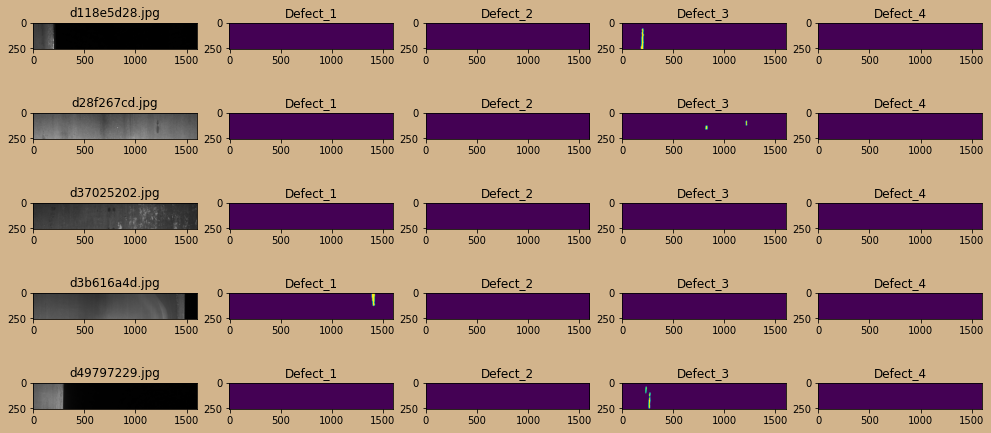

In [ ]:
plot_mask(df1[0:5])

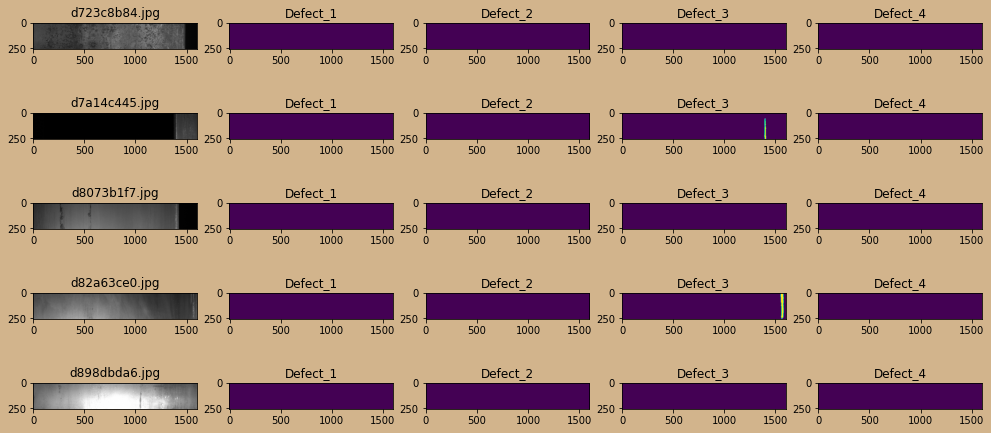

In [ ]:
plot_mask(df1[5:10])

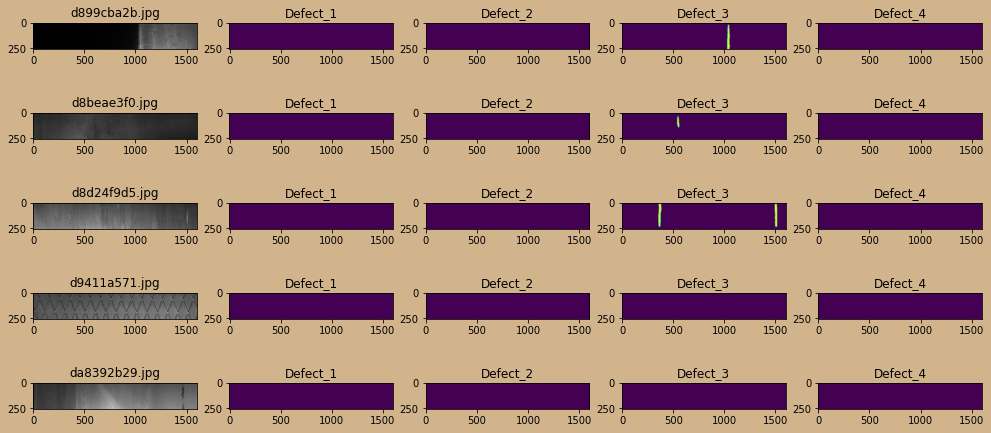

In [ ]:
plot_mask(df1[10:15])

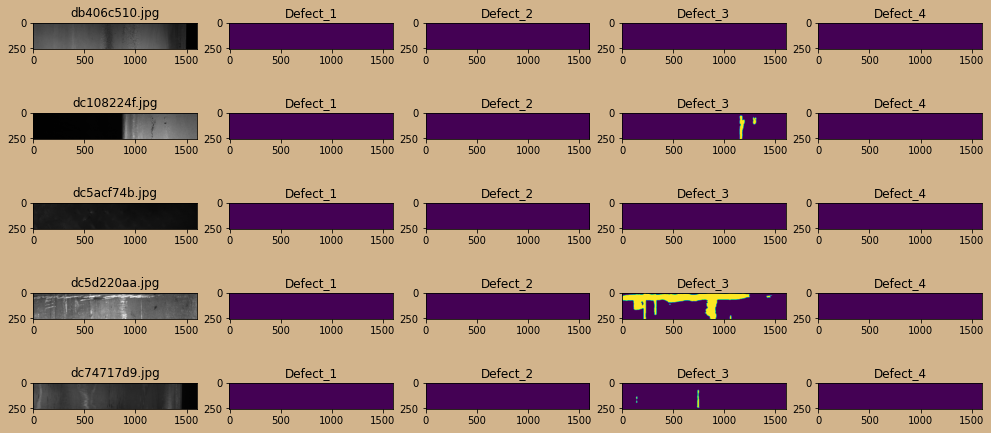

In [ ]:
plot_mask(df1[15:20])